In [35]:
!pip install tensorflow
!pip install tensorflow-datasets
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 39.2 MB/s eta 0:00:00


# 2 CIFAR-10 Classification

In [36]:
!nvidia-smi

Thu Dec 15 20:54:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:00:05.0 Off |                  Off |
| 41%   45C    P8    17W / 140W |  15501MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [37]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib as plt
import keras_cv

## 2.1 Prepare the dataset

In [62]:
num_labels=10

augmentation = tf.keras.Sequential([
  keras_cv.layers.RandAugment(value_range=[-1, 1], magnitude=0.1),
])

#augmentation = tf.keras.Sequential([
#  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#  tf.keras.layers.RandomRotation(0.2),
#])

def get_cifar10(augment=False, batch_size=32, shuffle_buffer_size=4096, prefetch_size=20):
  ds_train, ds_test = tfds.load('cifar10', 
                                split=['train', 'test'],
                                as_supervised=True,
                                shuffle_files=True)
  
  def prep(ds, augment=augment):
    # normalize images to [-1, 1]
    def normalize_img(image, label):
      return (tf.cast(image, float) / 128.) - 1, \
              tf.one_hot(label, depth=num_labels) 
    ds = ds.map(normalize_img)
    ds = ds.shuffle(shuffle_buffer_size) \
           .batch(batch_size)
    
    # optionally augment, but only the training set
    if augment:
      ds = ds.map(lambda img, target: (augmentation(img), target))
    
    return ds.prefetch(prefetch_size)
  
  return prep(ds_train, augment), prep(ds_test, augment=False) 

## 2.2 The CNN Model

In [67]:
class CNN(tf.keras.Model):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(units=num_labels, activation='softmax')
    ]
    
  def call(self, x):
    for layer in self.layer_list:
        x = layer(x)
    return x
  
def try_model(model, ds):
  for images, labels in ds.take(1):
    print(model(images).shape)

## 2.3 Training the network

In [68]:
def train(model, ds_train, ds_test, epochs=10):
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model.fit(ds_train, epochs=epochs, validation_data=ds_test)

### Training with no augmentation

Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7469 - accuracy: 0.3336 - val_loss: 1.5132 - val_accuracy: 0.4340
Epoch 2/15
1563/1563 [==============================] - 6s 3ms/step - loss: 1.4491 - accuracy: 0.4682 - val_loss: 1.4076 - val_accuracy: 0.4841
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3221 - accuracy: 0.5241 - val_loss: 1.2945 - val_accuracy: 0.5376
Epoch 4/15
1563/1563 [==============================] - 6s 3ms/step - loss: 1.2476 - accuracy: 0.5547 - val_loss: 1.2197 - val_accuracy: 0.5612
Epoch 5/15
1563/1563 [==============================] - 6s 3ms/step - loss: 1.1908 - accuracy: 0.5760 - val_loss: 1.1807 - val_accuracy: 0.5745
Epoch 6/15
1563/1563 [==============================] - 6s 3ms/step - loss: 1.1501 - accuracy: 0.5913 - val_loss: 1.1186 - val_accuracy: 0.6031
Epoch 7/15
1563/1563 [==============================] - 6s 3ms/step - loss: 1.1153 - accuracy: 0.6044 - val_loss: 1.1014 - val_accuracy:

<AxesSubplot:>

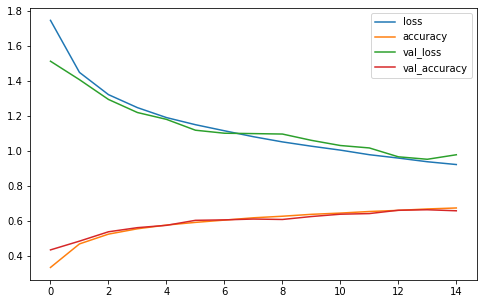

In [69]:
ds_train, ds_test = get_cifar10()
model = CNN()
model_history = train(model, ds_train, ds_test, 15)
pd.DataFrame(model_history.history).plot(figsize=(8,5))

### Training with augmentation

Epoch 1/15
1563/1563 [==============================] - 107s 68ms/step - loss: 1.8808 - accuracy: 0.2913 - val_loss: 1.5477 - val_accuracy: 0.4324
Epoch 2/15
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6394 - accuracy: 0.3948 - val_loss: 1.4568 - val_accuracy: 0.4611
Epoch 3/15
1563/1563 [==============================] - 105s 67ms/step - loss: 1.5236 - accuracy: 0.4443 - val_loss: 1.3459 - val_accuracy: 0.5119
Epoch 4/15
1563/1563 [==============================] - 104s 66ms/step - loss: 1.4401 - accuracy: 0.4790 - val_loss: 1.2775 - val_accuracy: 0.5431
Epoch 5/15
1563/1563 [==============================] - 106s 68ms/step - loss: 1.3885 - accuracy: 0.5011 - val_loss: 1.2530 - val_accuracy: 0.5549
Epoch 6/15
1563/1563 [==============================] - 103s 66ms/step - loss: 1.3400 - accuracy: 0.5171 - val_loss: 1.1987 - val_accuracy: 0.5690
Epoch 7/15
1563/1563 [==============================] - 107s 69ms/step - loss: 1.3043 - accuracy: 0.5341 - val_loss: 1

<AxesSubplot:>

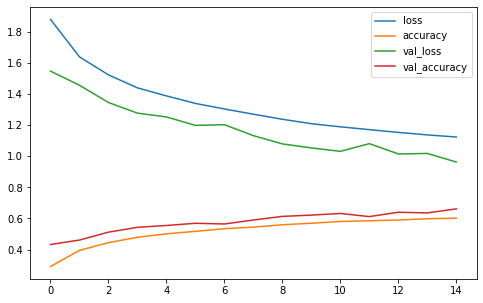

In [70]:
ds_train, ds_test = get_cifar10(augment=True)
model = CNN()
model_history = train(model, ds_train, ds_test, 15)
pd.DataFrame(model_history.history).plot(figsize=(8,5))

### Training with batch normalization

In [72]:
class CNNBatchNormalization(CNN):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(units=num_labels, activation='softmax')
    ]

Epoch 1/15
1563/1563 [==============================] - 8s 4ms/step - loss: 1.4533 - accuracy: 0.4759 - val_loss: 1.2935 - val_accuracy: 0.5345
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1594 - accuracy: 0.5883 - val_loss: 1.0539 - val_accuracy: 0.6269
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0401 - accuracy: 0.6342 - val_loss: 0.9915 - val_accuracy: 0.6489
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9546 - accuracy: 0.6660 - val_loss: 0.9504 - val_accuracy: 0.6664
Epoch 5/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9019 - accuracy: 0.6855 - val_loss: 0.9336 - val_accuracy: 0.6684
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8622 - accuracy: 0.6982 - val_loss: 0.8751 - val_accuracy: 0.6924
Epoch 7/15
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8340 - accuracy: 0.7093 - val_loss: 0.8382 - val_accuracy:

<AxesSubplot:>

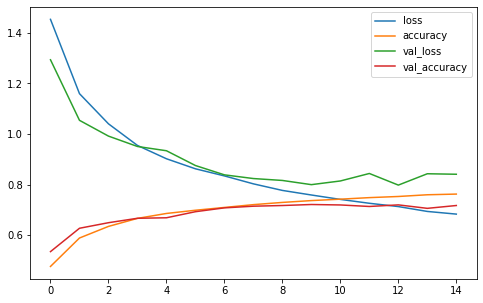

In [73]:
ds_train, ds_test = get_cifar10()
model = CNNBatchNormalization()
model_history = train(model, ds_train, ds_test, 15)
pd.DataFrame(model_history.history).plot(figsize=(8,5))

### L2 Regularization

In [74]:
class CNNRegularization(CNN):
  def __init__(self):
    super(CNN, self).__init__()
    
    regularizer = tf.keras.regularizers.l2(0.01)
    
    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizer),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizer),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizer),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizer),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(units=num_labels, activation='softmax')
    ]

Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 2.0618 - accuracy: 0.2389 - val_loss: 1.9162 - val_accuracy: 0.3014
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8986 - accuracy: 0.2949 - val_loss: 1.8611 - val_accuracy: 0.3123
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8626 - accuracy: 0.3108 - val_loss: 1.8349 - val_accuracy: 0.3389
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8408 - accuracy: 0.3248 - val_loss: 1.8457 - val_accuracy: 0.3294
Epoch 5/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8243 - accuracy: 0.3369 - val_loss: 1.8374 - val_accuracy: 0.3314
Epoch 6/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.8112 - accuracy: 0.3425 - val_loss: 1.7947 - val_accuracy: 0.3442
Epoch 7/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8020 - accuracy: 0.3477 - val_loss: 1.7915 - val_accuracy:

<AxesSubplot:>

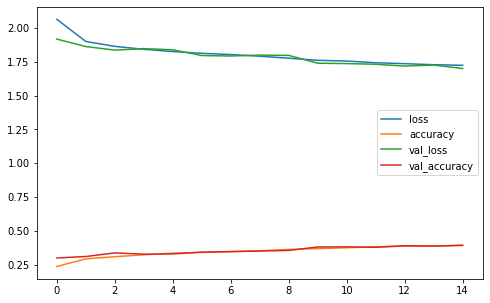

In [75]:
ds_train, ds_test = get_cifar10()
model = CNNRegularization()
model_history = train(model, ds_train, ds_test, 15)
pd.DataFrame(model_history.history).plot(figsize=(8,5))

### Dropout

In [84]:
class CNNDropout(CNN):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.dropout = tf.keras.layers.Dropout(0.5)
    
    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(units=num_labels, activation='softmax')
    ]
    
  def call(self, x, training=False):
    for layer in self.layer_list:
      x = layer(x)
        
    return x

Epoch 1/15
1563/1563 [==============================] - 7s 4ms/step - loss: 1.7233 - accuracy: 0.3482 - val_loss: 1.4990 - val_accuracy: 0.4468
Epoch 2/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4613 - accuracy: 0.4676 - val_loss: 1.3993 - val_accuracy: 0.4973
Epoch 3/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3698 - accuracy: 0.5067 - val_loss: 1.3762 - val_accuracy: 0.5059
Epoch 4/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3094 - accuracy: 0.5310 - val_loss: 1.2360 - val_accuracy: 0.5620
Epoch 5/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2638 - accuracy: 0.5472 - val_loss: 1.2262 - val_accuracy: 0.5650
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2238 - accuracy: 0.5664 - val_loss: 1.3240 - val_accuracy: 0.5319
Epoch 7/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1930 - accuracy: 0.5749 - val_loss: 1.1992 - val_accuracy:

<AxesSubplot:>

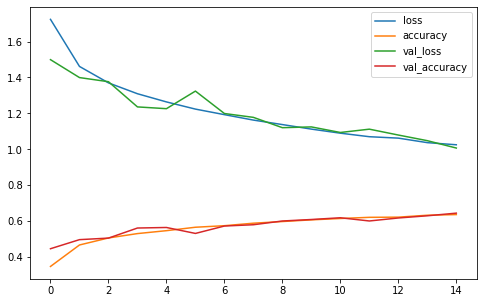

In [85]:
ds_train, ds_test = get_cifar10()
model = CNNDropout()
model_history = train(model, ds_train, ds_test, 15)
pd.DataFrame(model_history.history).plot(figsize=(8,5))

### Using custom initialization (He)

In [86]:
class CNNInitializer(CNN):
  def __init__(self):
    super(CNN, self).__init__()
    
    initializer = tf.keras.initializers.he_normal()
    
    self.layer_list = [
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer=initializer),
      tf.keras.layers.GlobalAvgPool2D(),
      tf.keras.layers.Dense(units=num_labels, activation='softmax')
    ]

Epoch 1/15
1563/1563 [==============================] - 8s 5ms/step - loss: 1.7187 - accuracy: 0.3554 - val_loss: 1.5051 - val_accuracy: 0.4446
Epoch 2/15
1563/1563 [==============================] - 6s 3ms/step - loss: 1.4248 - accuracy: 0.4818 - val_loss: 1.3180 - val_accuracy: 0.5192
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.2837 - accuracy: 0.5395 - val_loss: 1.2211 - val_accuracy: 0.5620
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1994 - accuracy: 0.5732 - val_loss: 1.1867 - val_accuracy: 0.5848
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1357 - accuracy: 0.5992 - val_loss: 1.1032 - val_accuracy: 0.6073
Epoch 6/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0815 - accuracy: 0.6193 - val_loss: 1.0942 - val_accuracy: 0.6044
Epoch 7/15
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0441 - accuracy: 0.6341 - val_loss: 1.0697 - val_accuracy:

<AxesSubplot:>

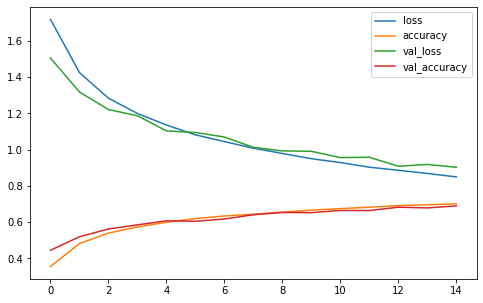

In [87]:
ds_train, ds_test = get_cifar10()
model = CNNInitializer()
model_history = train(model, ds_train, ds_test, 15)
pd.DataFrame(model_history.history).plot(figsize=(8,5))